## Import all the Dependencies

In [52]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

## Import data into tensorflow dataset object

In [53]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
EPOCHS = 50
CHANNELS = 3

dataset = tf.keras.utils.image_dataset_from_directory(
    'PlantVillage',
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [54]:
print(len(dataset))

68


## Visualize the dataset

In [55]:
className = dataset.class_names

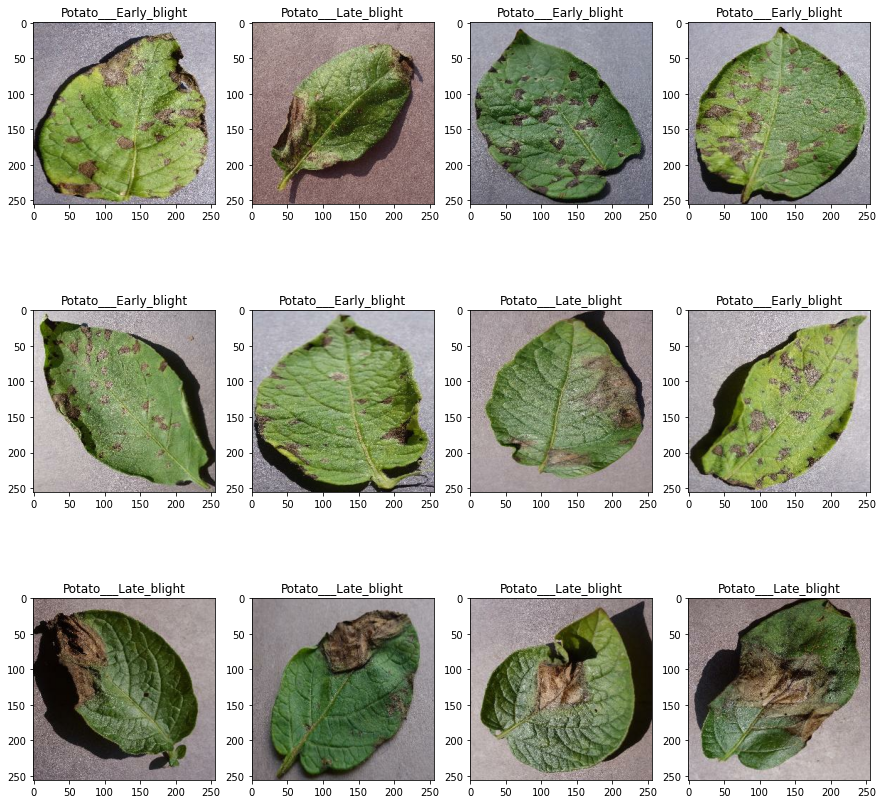

In [56]:
plt.figure(figsize=(15,15))
for image_batch,label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(className[label_batch[i]])


## Split Dataset Function

In [57]:
def split_dataset(dataset, train_split = 0.8, validation_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size = 10000):
    dataset_len = len(dataset)
    
    if shuffle:
        dataset = dataset.shuffle(shuffle_size, seed = 12)
        
    train_size = int(dataset_len * train_split)
    validation_size = int(dataset_len * validation_split)
    
    train_dataset = dataset.take(train_size)
    
    val_dataset = dataset.skip(train_size).take(validation_size)
    
    test_dataset = dataset.skip(train_size).skip(validation_size)
    
    return train_dataset, val_dataset, test_dataset

In [58]:
 train_dataset, val_dataset, test_dataset = split_dataset(dataset)

In [59]:
print(len(train_dataset))

54


In [60]:
print(len(val_dataset))

6


In [61]:
print(len(test_dataset))

8


In [62]:
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Resizing and Normalization

In [63]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

# Data Augmentation

In [64]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

# Convolutional neural network (CNN)

In [65]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_5 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_12 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (32, 127, 127, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (32, 62, 62, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (32, 60, 60, 64)         

# Compiling the Model

In [66]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [67]:
history = model.fit(
    train_dataset,
    batch_size=BATCH_SIZE,
    validation_data=val_dataset,
    verbose=1,
    epochs=30,
)

Epoch 1/30
54/54 [==============================] - 50s 907ms/step - loss: 0.9134 - accuracy: 0.5023 - val_loss: 0.9811 - val_accuracy: 0.6510
Epoch 2/30
54/54 [==============================] - 50s 932ms/step - loss: 0.7239 - accuracy: 0.6719 - val_loss: 0.5941 - val_accuracy: 0.7656
Epoch 3/30
54/54 [==============================] - 53s 979ms/step - loss: 0.4751 - accuracy: 0.8166 - val_loss: 0.4283 - val_accuracy: 0.8177
Epoch 4/30
54/54 [==============================] - 54s 998ms/step - loss: 0.4160 - accuracy: 0.8380 - val_loss: 0.4045 - val_accuracy: 0.8125
Epoch 5/30
54/54 [==============================] - 56s 1s/step - loss: 0.3329 - accuracy: 0.8727 - val_loss: 0.2568 - val_accuracy: 0.9062
Epoch 6/30
54/54 [==============================] - 56s 1s/step - loss: 0.2430 - accuracy: 0.9051 - val_loss: 0.2390 - val_accuracy: 0.8958
Epoch 7/30
54/54 [==============================] - 57s 1s/step - loss: 0.2352 - accuracy: 0.9074 - val_loss: 0.4533 - val_accuracy: 0.8333
Epoch 8/

In [68]:
scores = model.evaluate(test_dataset)

8/8 [==============================] - 3s 245ms/step - loss: 0.0081 - accuracy: 0.9961


In [69]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

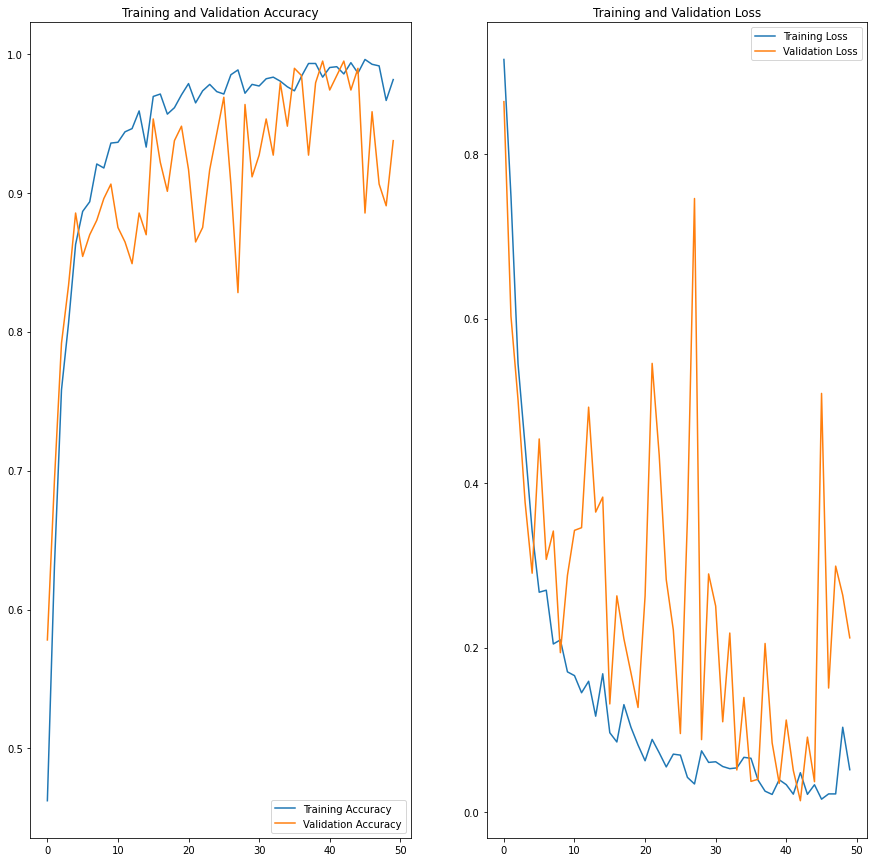

In [37]:
plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Write predict function

In [70]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = className[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 24ms/step


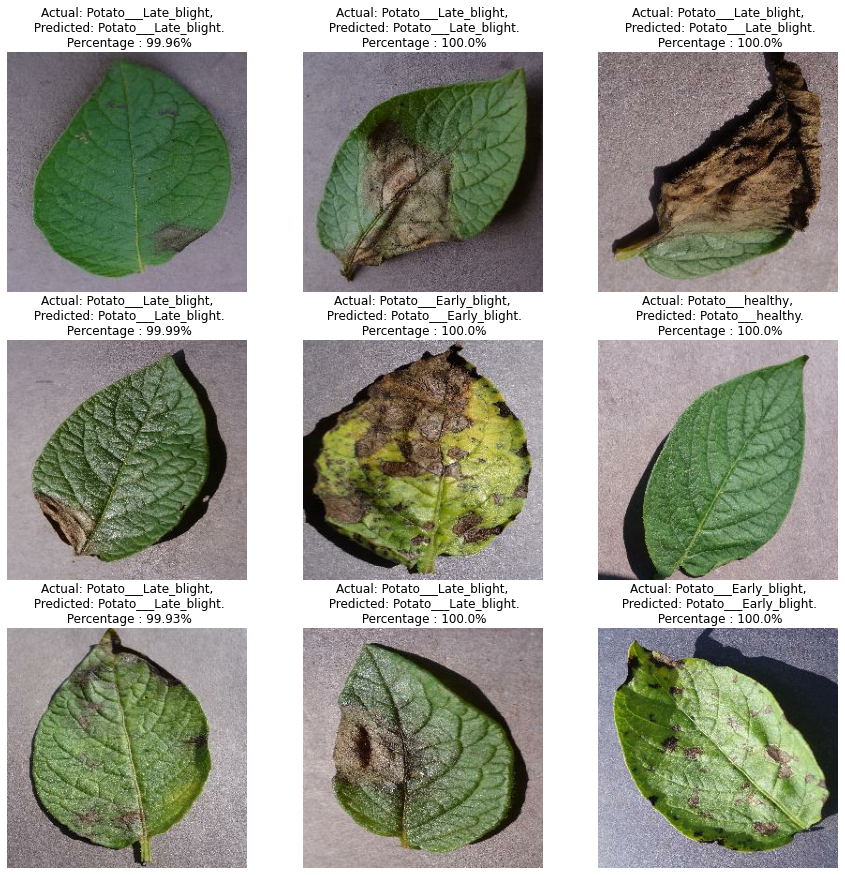

In [72]:
plt.figure(figsize=(15, 15))
for images, labels in test_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = className[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Percentage : {confidence}%")
        
        plt.axis("off")